# Instruction Following

In this notebook, we study the instruction following ability of a model across a range of instruction types. Additionally, we inspect if steering the model to be better at following instructions impacts the model's response quality in general.

## Setup

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from datasets import load_dataset
from transformers import logging as hf_logging

from aisteer360.algorithms.state_control.pasta.control import PASTA
from aisteer360.algorithms.core.specs import ControlSpec
from aisteer360.evaluation.use_cases.instruction_following import InstructionFollowing
from aisteer360.evaluation.metrics.custom.instruction_following.strict_instruction import StrictInstruction
from aisteer360.evaluation.metrics.generic.reward_score import RewardScore
from aisteer360.evaluation.benchmark import Benchmark
from aisteer360.evaluation.utils import (
    flatten_profiles,
    summarize_by_config,
    get_param_values,
    build_per_example_df,
    to_jsonable,
)
from aisteer360.evaluation.utils.viz_utils import (
    plot_metric_heatmap,
    plot_sensitivity,
    plot_tradeoff_with_pareto,
)

hf_logging.set_verbosity_error()
MODEL_NAME = "Qwen/Qwen2.5-1.5B-Instruct"

## Data preparation

There are innumerable types of instructions that a model can be prompted with. To better understand a model's instruction following ability, we explore model behavior across a specific set of instruction types as organized by the `IFEval` dataset. For the purposes of this study, we make use of our modified version of the IFEval dataset, termed `Split-IFEval`, in which the instructions are explicitly extracted from the prompt (this makes it easier to create interventions that rely directly on these tokens).

In [ ]:
ifeval = load_dataset("ibm-research/Split-IFEval")
ifeval_df = ifeval["train"].to_pandas()

cols = ["instructions", "instruction_id_list", "kwargs"]
for col in cols:
    ifeval_df[col] = ifeval_df[col].apply(
        lambda x: x.tolist() if isinstance(x, np.ndarray) else x
    )

ifeval_df

,key,prompt,instruction_id_list,kwargs,separated_prompt,instructions,original_prompt
0,1000,"Write a summary of the wikipedia page ""https:/...","[punctuation:no_comma, detectable_format:numbe...","[{'num_bullets': None, 'num_highlights': None,...","Write a summary of the wikipedia page ""https:/...","[- Write 300+ words, - Do not use any commas, ...",Write a 300+ word summary of the wikipedia pag...
1,1001,"I am planning a trip to Japan, and I would lik...",[punctuation:no_comma],"[{'num_bullets': None, 'num_highlights': None,...","I am planning a trip to Japan, and I would lik...",[- You are not allowed to use any commas in yo...,"I am planning a trip to Japan, and I would lik..."
2,1005,Write a resume for a fresh high school graduat...,[detectable_content:number_placeholders],"[{'num_bullets': None, 'num_highlights': None,...",Write a resume for a fresh high school graduat...,[- Make sure to include at least 12 placeholde...,Write a resume for a fresh high school graduat...
3,1012,Write an email to my boss telling him that I a...,"[combination:repeat_prompt, detectable_format:...","[{'num_bullets': None, 'num_highlights': None,...",Write an email to my boss telling him that I a...,[- First repeat the request word for word with...,Write an email to my boss telling him that I a...
4,1019,"Given the sentence ""Two young boys with toy gu...",[change_case:english_lowercase],"[{'num_bullets': None, 'num_highlights': None,...","Given the sentence ""Two young boys with toy gu...",[- Please ensure that your response is in Engl...,"Given the sentence ""Two young boys with toy gu..."
...,...,...,...,...,...,...,...
536,3753,If a + b + c = 30 and b = 10 and c = 5. Is a =...,[detectable_format:constrained_response],"[{'num_bullets': None, 'num_highlights': None,...",If a + b + c = 30 and b = 10 and c = 5. Is a =...,"[- Answer ""My answer is yes."" or ""My answer is...",If a + b + c = 30 and b = 10 and c = 5. Is a =...
537,3754,If Bob beat Martha in a game of pool. And Mart...,[detectable_format:constrained_response],"[{'num_bullets': None, 'num_highlights': None,...",If Bob beat Martha in a game of pool. And Mart...,[- Your answer must contain exactly one of the...,If Bob beat Martha in a game of pool. And Mart...
538,3755,Can Batman beat Superman in a fair one on one ...,[detectable_format:constrained_response],"[{'num_bullets': None, 'num_highlights': None,...",Can Batman beat Superman in a fair one on one ...,"[- You should just say ""My answer is yes."" or ...",Can Batman beat Superman in a fair one on one ...
539,3756,Is Pikachu one of the Avengers?\n\nYour respon...,[detectable_format:constrained_response],"[{'num_bullets': None, 'num_highlights': None,...",Is Pikachu one of the Avengers?,"[- Think out loud, then answer with one of the...",Is Pikachu one of the Avengers? Think out loud...


Notice via the `instruction_id_list` column, each prompt can in general contain a number of instructions. We'll focus on the prompts that contain a single example.

In [ ]:
ifeval_df["num_instructions"] = ifeval_df["instruction_id_list"].apply(len)
single_instr_df = ifeval_df[ifeval_df["num_instructions"] == 1].copy()
single_instr_df["instruction_id"] = single_instr_df["instruction_id_list"].apply(lambda ids: ids[0])
instruction_group_sizes = (
    single_instr_df["instruction_id"]
    .value_counts()
    .rename_axis("instruction_id")
    .reset_index(name="count")
)

instruction_group_sizes.head(20)

,instruction_id,count
0,keywords:forbidden_words,19
1,detectable_format:number_highlighted_sections,19
2,combination:repeat_prompt,18
3,startend:end_checker,17
4,language:response_language,17
5,punctuation:no_comma,16
6,startend:quotation,14
7,detectable_format:number_bullet_lists,13
8,change_case:english_lowercase,13
9,detectable_format:title,13


We'll study the following instruction types:

- `keywords:forbidden_words`: describes that the response must avoid using anything from the specified forbidden list.
- `detectable_format:number_highlighted_sections`: describes that the response must contain at least a specified number of highlighted sections using a defined markup pattern.
- `language:response_language`: indicates that the model must generate its entire response in a specific target language.
- `startend:end_checker`: describes that the response must end with an exact required phrase (with nothing extra following it).

In [ ]:
instruction_types = [
    "keywords:forbidden_words",
    "detectable_format:number_highlighted_sections",
    "language:response_language",
    "startend:end_checker",
]

filtered_df = single_instr_df[
    single_instr_df["instruction_id"].isin(instruction_types)
].copy()

balanced_filtered = (
    filtered_df.groupby("instruction_id")
    .apply(lambda g: g.sample(min(len(g), 12), random_state=123))
    .reset_index(drop=True)
)

balanced_filtered

/tmp/ipykernel_1847635/3282579761.py:14: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda g: g.sample(min(len(g), 12), random_state=123))


,key,prompt,instruction_id_list,kwargs,separated_prompt,instructions,original_prompt,num_instructions,instruction_id
0,3644,Write a blog post about interesting facts abou...,[detectable_format:number_highlighted_sections],"[{'num_bullets': None, 'num_highlights': 2.0, ...",Write a blog post about interesting facts abou...,[- Italicize at least 2 sections in your answe...,Write a blog post about interesting facts abou...,1,detectable_format:number_highlighted_sections
1,1773,Write a song about the summers of my childhood...,[detectable_format:number_highlighted_sections],"[{'num_bullets': None, 'num_highlights': 1.0, ...",Write a song about the summers of my childhood...,"[- Give the song a name, and highlight the nam...",Write a song about the summers of my childhood...,1,detectable_format:number_highlighted_sections
2,168,Write a funny and sarcastic template for ratin...,[detectable_format:number_highlighted_sections],"[{'num_bullets': None, 'num_highlights': 3.0, ...",Write a funny and sarcastic template for ratin...,[- Please highlight at least 3 sections with m...,Write a funny and sarcastic template for ratin...,1,detectable_format:number_highlighted_sections
3,3549,Write a funny Haiku about a Quaker named John ...,[detectable_format:number_highlighted_sections],"[{'num_bullets': None, 'num_highlights': 2.0, ...",Write a funny Haiku about a Quaker named John ...,"[- Use the asterisk symbol, *, to highlight so...",Write a funny Haiku about a Quaker named John ...,1,detectable_format:number_highlighted_sections
4,2253,Write a template for a workshop on the importa...,[detectable_format:number_highlighted_sections],"[{'num_bullets': None, 'num_highlights': 3.0, ...",Write a template for a workshop on the importa...,[- Highlight at least 3 sections with markdown...,Write a template for a workshop on the importa...,1,detectable_format:number_highlighted_sections
5,2790,Write a funny rap about a man who gets a call ...,[detectable_format:number_highlighted_sections],"[{'num_bullets': None, 'num_highlights': 1.0, ...",Write a funny rap about a man who gets a call ...,[- Use markdown to highlight at least one sect...,Write a funny rap about a man who gets a call ...,1,detectable_format:number_highlighted_sections
6,2381,Write a cover letter to a local political part...,[detectable_format:number_highlighted_sections],"[{'num_bullets': None, 'num_highlights': 3.0, ...",Write a cover letter to a local political part...,[- Make sure to highlight at least 3 sections ...,Write a cover letter to a local political part...,1,detectable_format:number_highlighted_sections
7,1307,Write an outline for a paper on the history of...,[detectable_format:number_highlighted_sections],"[{'num_bullets': None, 'num_highlights': 15.0,...",Write an outline for a paper on the history of...,[- The outline should include the main points ...,Write an outline for a paper on the history of...,1,detectable_format:number_highlighted_sections
8,3071,Write a rap about the renaissance.\n\nYour res...,[detectable_format:number_highlighted_sections],"[{'num_bullets': None, 'num_highlights': 3.0, ...",Write a rap about the renaissance.,[- It should be noticeably different from raps...,Write a rap about the renaissance. It should b...,1,detectable_format:number_highlighted_sections
9,3453,Summarize the history of Japan.\n\nYour respon...,[detectable_format:number_highlighted_sections],"[{'num_bullets': None, 'num_highlights': 5.0, ...",Summarize the history of Japan.,[- Italicize at least 5 keywords in your respo...,Summarize the history of Japan. Italicize at l...,1,detectable_format:number_highlighted_sections


Evaluation data takes the form of a prompt (including instructions), the specific instructions (separated from the prompt), the IDs of the instructions, and any associated kwargs for the instructions.

In [ ]:
evaluation_data = [
    {
        "prompt": row["prompt"],
        "instructions": to_jsonable(row["instructions"]),
        "instruction_id_list": to_jsonable(row["instruction_id_list"]),
        "kwargs": to_jsonable(row["kwargs"]),
    }
    for _, row in balanced_filtered.iterrows()
]

len(evaluation_data), evaluation_data[0]

(48,
 {'prompt': 'Write a blog post about interesting facts about the Dutch language.\n\nYour response should follow the instructions below:\n- Italicize at least 2 sections in your answer with markdown, i.e. *italic text*',
  'instructions': ['- Italicize at least 2 sections in your answer with markdown, i.e. *italic text*'],
  'instruction_id_list': ['detectable_format:number_highlighted_sections'],
  'kwargs': [{'num_bullets': None,
    'num_highlights': 2.0,
    'relation': None,
    'num_words': None,
    'capital_relation': None,
    'capital_frequency': None,
    'num_sentences': None,
    'end_phrase': None,
    'keyword': None,
    'frequency': None,
    'prompt_to_repeat': None,
    'first_word': None,
    'num_paragraphs': None,
    'nth_paragraph': None,
    'let_relation': None,
    'letter': None,
    'let_frequency': None,
    'section_spliter': None,
    'num_sections': None,
    'postscript_marker': None,
    'forbidden_words': None,
    'num_placeholders': None,
    '

## Defining the benchmark

We use the `ControlSpec` class to sweep the steering strength `alpha`. The impacted layers and the method are assumed to be fixed throughout.

In [ ]:
pasta_spec = ControlSpec(
    control_cls=PASTA,
    params={
        "head_config": list(range(8, 24)),
        "scale_position": "include",
    },
    vars=[
        {"alpha": 5.0},
        {"alpha": 10.0},
        {"alpha": 15.0},
        {"alpha": 20.0},
        {"alpha": 25.0},
        {"alpha": 30.0},
    ],
    name="PASTA",
)

The instruction following use case is initialized with two metrics: `StrictInstruction` and `RewardScore`. We will be studying the trade-off between these two metrics.

In [ ]:
instruction_following = InstructionFollowing(
    evaluation_data=evaluation_data,
    evaluation_metrics=[
        StrictInstruction(),
        RewardScore(
            model_or_id="OpenAssistant/reward-model-deberta-v3-large-v2",
            score_transform="identity",
            batch_size=8,
            max_length=1024,
            return_logits=False,
        )
    ],
)

The benchmark can then be defined on two steering pipelines: the baseline (unsteered) model, and the above `pasta_spec`. Note the use of `runtime_overrides` to inform PASTA that it should populate its internal `substrings` argument with the `instructions` column from `evaluation_data`.

In [ ]:
benchmark = Benchmark(
    use_case=instruction_following,
    base_model_name_or_path=MODEL_NAME,
    steering_pipelines={
        "baseline": [],
        "pasta_alpha_sweep": [pasta_spec],
    },
    runtime_overrides={
        "PASTA": {"substrings": "instructions"},
    },
    gen_kwargs={
        "max_new_tokens": 128,
        "do_sample": True,
        "output_attentions": True,
    },
    hf_model_kwargs={
        "attn_implementation": "eager",
    },
    device_map="auto",
    num_trials=3
)

Running the benchmark yields the profiles across the baseline and the full set of configurations in the spec.

In [ ]:
profiles = benchmark.run()

Running pipeline: baseline...


done.
Running pipeline: pasta_alpha_sweep...
Running configuration 1...
Running configuration 2...
Running configuration 3...


## Analysis

We can now examine the relationship between steering strength and both instruction following and response quality. The following sections break down the results by configuration, visualize the accuracy-reward tradeoff, and provide per-example and per-instruction-type analyses.

We first convert the nested benchmark output into a flat DataFrame with one row per run, extracting the metrics of interest (via `flatten_profiles`).

In [ ]:
runs_df = flatten_profiles(
    profiles,
    metric_accessors={
        "strict_prompt_acc": ("StrictInstruction", "strict_prompt_accuracy"),
        "strict_instr_acc": ("StrictInstruction", "strict_instruction_accuracy"),
        "mean_reward": ("RewardScore", "mean_reward"),
    }
)

# extract the swept alpha parameter as a column
runs_df["alpha"] = get_param_values(runs_df, "PASTA", "alpha")

display(
    runs_df
    .drop(columns=["_run", "params"])
    .sort_values(["alpha", "trial_id"], na_position="last")
    .reset_index(drop=True)
)

,pipeline,trial_id,config_id,strict_prompt_acc,strict_instr_acc,mean_reward,alpha
0,pasta_alpha_sweep,0,ab6a3b5c,0.479167,0.479167,-1.645711,5.0
1,pasta_alpha_sweep,1,ab6a3b5c,0.500000,0.500000,-1.762594,5.0
2,pasta_alpha_sweep,2,ab6a3b5c,0.541667,0.541667,-1.710529,5.0
3,pasta_alpha_sweep,3,ab6a3b5c,0.583333,0.583333,-1.559070,5.0
4,pasta_alpha_sweep,4,ab6a3b5c,0.541667,0.541667,-1.695049,5.0
5,pasta_alpha_sweep,5,ab6a3b5c,0.520833,0.520833,-1.600259,5.0
6,pasta_alpha_sweep,6,ab6a3b5c,0.604167,0.604167,-1.606826,5.0
7,pasta_alpha_sweep,7,ab6a3b5c,0.520833,0.520833,-1.461369,5.0
8,pasta_alpha_sweep,0,2c3487a0,0.562500,0.562500,-2.004146,10.0
9,pasta_alpha_sweep,1,2c3487a0,0.604167,0.604167,-1.836194,10.0


### Summarizing by configuration

Next, we aggregate metrics across trials to compute mean and standard deviation for each configuration. This provides a clearer picture of performance variability.

In [ ]:
# summarize across trials
summary = summarize_by_config(
    runs_df,
    metric_cols=["strict_prompt_acc", "strict_instr_acc", "mean_reward"],
    group_cols=["pipeline", "config_id"],
)

# add alpha back from runs_df (first value per config)
alpha_map = runs_df.groupby(["pipeline", "config_id"])["alpha"].first()
summary["alpha"] = summary.apply(
    lambda row: alpha_map.get((row["pipeline"], row["config_id"]), np.nan), axis=1
)

# add a readable config label and steering strength (-log(alpha))
summary["config"] = summary["alpha"].apply(
    lambda a: "baseline" if pd.isna(a) else f"alpha={a}"
)
summary["steering_strength"] = summary["alpha"].apply(
    lambda a: 0.0 if pd.isna(a) else -np.log(a)
)

display(summary[[
    "config", "alpha", "steering_strength", "n_trials",
    "strict_prompt_acc_mean", "strict_prompt_acc_std",
    "mean_reward_mean", "mean_reward_std"
]].sort_values("steering_strength").round(4))

,config,alpha,steering_strength,n_trials,strict_prompt_acc_mean,strict_prompt_acc_std,mean_reward_mean,mean_reward_std
6,alpha=30.0,30.0,-3.4012,8.0,0.4922,0.0771,-2.7003,0.1520
5,alpha=25.0,25.0,-3.2189,8.0,0.4896,0.0445,-2.4524,0.1108
4,alpha=20.0,20.0,-2.9957,8.0,0.5495,0.0567,-2.4478,0.0874
3,alpha=15.0,15.0,-2.7081,8.0,0.5964,0.0314,-2.1903,0.1649
2,alpha=10.0,10.0,-2.3026,8.0,0.5781,0.0289,-1.8756,0.0830
1,alpha=5.0,5.0,-1.6094,8.0,0.5365,0.0413,-1.6302,0.0952
0,baseline,NaN,0.0000,8.0,0.5365,0.0469,-1.5014,0.0759


### Tradeoff visualization

The 3-panel figure below shows how instruction following and response quality each vary with steering strength (-log(alpha)), along with their joint tradeoff. The baseline (unsteered) model is shown for reference. 

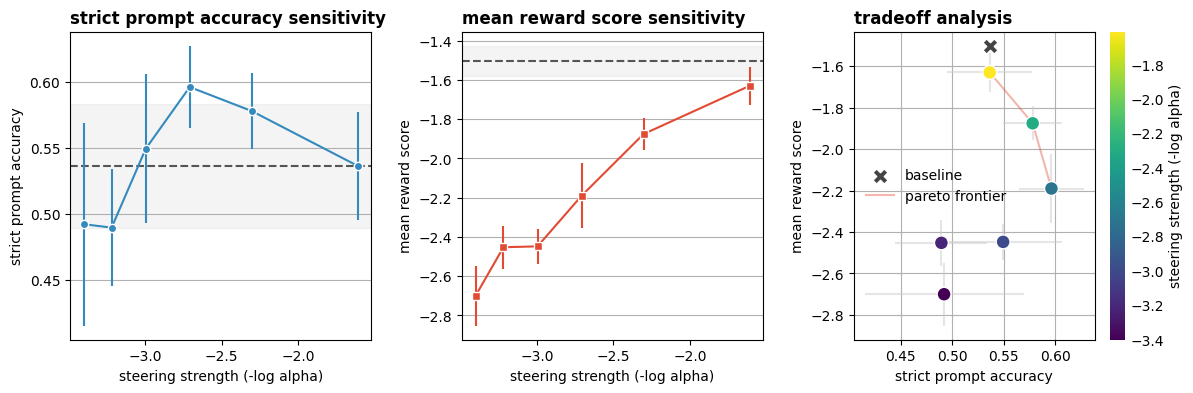

In [ ]:
baseline = summary[summary["pipeline"] == "baseline"]
swept = summary[summary["pipeline"] != "baseline"].sort_values("steering_strength")

fig = plt.figure(figsize=(14, 4))
gs = gridspec.GridSpec(1, 3, width_ratios=[1, 1, 1], wspace=0.3)
axes = [fig.add_subplot(gs[0, i]) for i in range(3)]

# instruction following sensitivity
plot_sensitivity(
    swept,
    metric="strict_prompt_acc",
    sweep_col="steering_strength",
    baseline=baseline,
    ax=axes[0],
    metric_label="strict prompt accuracy",
    sweep_label="steering strength (-log alpha)",
    color="#348ABD",
    marker="o",
)

# reward sensitivity
plot_sensitivity(
    swept,
    metric="mean_reward",
    sweep_col="steering_strength",
    baseline=baseline,
    ax=axes[1],
    metric_label="mean reward score",
    sweep_label="steering strength (-log alpha)",
    color="#E24A33",
    marker="s",
)

# tradeoff scatter with Pareto frontier
plot_tradeoff_with_pareto(
    swept,
    x_metric="strict_prompt_acc",
    y_metric="mean_reward",
    sweep_col="steering_strength",
    baseline=baseline,
    ax=axes[2],
    x_label="strict prompt accuracy",
    y_label="mean reward score",
    sweep_label="steering strength (-log alpha)",
)

plt.savefig("pasta_tradeoff_analysis.png", dpi=300, bbox_inches="tight")
plt.show()

### Per-example analysis

We can drill down to individual examples to understand which prompts benefited from steering. Here we compare the baseline against a steered configuration to find cases where steering fixed instruction following, and examine the impact on reward.

In [ ]:
def get_run_by_config(runs_df: pd.DataFrame, pipeline: str, alpha=None, trial_id: int = 0):
    """Get a specific run from the flattened DataFrame."""
    if pipeline == "baseline":
        mask = (runs_df["pipeline"] == "baseline") & (runs_df["trial_id"] == trial_id)
    else:
        mask = (runs_df["pipeline"] == pipeline) & (runs_df["alpha"] == alpha) & (runs_df["trial_id"] == trial_id)
    return runs_df.loc[mask, "_run"].iloc[0]

In [ ]:
pasta_summary = summary[summary["config"] != "baseline"]
strongest_alpha = pasta_summary["alpha"].min()

baseline_run = get_run_by_config(runs_df, "baseline")
strong_run = get_run_by_config(runs_df, "pasta_alpha_sweep", strongest_alpha)

baseline_ex = build_per_example_df(
    baseline_run,
    generation_fields=["prompt", "response", "instruction_id_list"],
    metric_lists={
        "followed": ("StrictInstruction", "follow_all_instructions"),
        "reward": ("RewardScore", "rewards"),
    }
)
strong_ex = build_per_example_df(
    strong_run,
    generation_fields=["prompt", "response", "instruction_id_list"],
    metric_lists={
        "followed": ("StrictInstruction", "follow_all_instructions"),
        "reward": ("RewardScore", "rewards"),
    }
)

# find cases where steering fixed instruction following
comparison = baseline_ex[["idx", "followed", "reward"]].merge(
    strong_ex[["idx", "followed", "reward"]],
    on="idx", suffixes=("_base", "_strong")
)
fixed = comparison[(~comparison["followed_base"]) & (comparison["followed_strong"])].copy()
fixed["reward_delta"] = fixed["reward_strong"] - fixed["reward_base"]

fixed.sort_values("reward_delta")[["idx", "reward_base", "reward_strong", "reward_delta"]]

,idx,reward_base,reward_strong,reward_delta
43,43,0.214243,-0.846570,-1.060813
10,10,0.109214,-0.304146,-0.413360
3,3,-3.059064,-2.009326,1.049738
2,2,-5.365365,-3.137730,2.227634


Below we print a specific example where steering improved instruction following.

In [ ]:
if not fixed.empty:
    example_idx = fixed.iloc[0]["idx"]
    base_row = baseline_ex[baseline_ex["idx"] == example_idx].iloc[0]
    steered_row = strong_ex[strong_ex["idx"] == example_idx].iloc[0]
    
    print("PROMPT:")
    print(base_row["prompt"][:500] + "..." if len(base_row["prompt"]) > 500 else base_row["prompt"])

    print("INSTRUCTION:")
    print(base_row["instruction_id_list"])

    print("BASELINE RESPONSE (followed={}, reward={:.2f}):".format(base_row["followed"], base_row["reward"]))
    print(base_row["response"][:500] + "..." if len(base_row["response"]) > 500 else base_row["response"])

    print("STEERED RESPONSE (followed={}, reward={:.2f}):".format(steered_row["followed"], steered_row["reward"]))
    print(steered_row["response"][:500] + "..." if len(steered_row["response"]) > 500 else steered_row["response"])

PROMPT:
Write a funny and sarcastic template for rating the quality of a marriage between two people who are both moms. This is for the couple themselves.

Your response should follow the instructions below:
- Please highlight at least 3 sections with markdown, i.e *highlighted section*
INSTRUCTION:
['detectable_format:number_highlighted_sections']
BASELINE RESPONSE (followed=False, reward=-5.37):
# Marriage Quality Rating Template

## Section 1: The Early Days (0 to 5 Stars)
**Rating:** ★☆☆☆☆  
**Reasoning:** It's hard to imagine how things could get better than when you wake up next to your partner in the morning, holding hands and sharing stories about the day ahead. But as time passes, reality sets in – kids come into the picture, schedules get disrupted, and the days blur together like a never-ending stream of diapers and tantrums. Oh, well, maybe that’s just life, right?

## Section...
STEERED RESPONSE (followed=True, reward=-3.14):
Sure, here's your template:

1. **Quality of Ma

### Per-instruction-type breakdown

Different instruction types may respond differently to steering. The heatmaps below show instruction following rate and response quality across instruction types and steering strengths.

In [ ]:
def extract_per_instruction_results(profiles, evaluation_data):
    """Break down results by instruction type and alpha."""
    rows = []

    for pipeline_name, runs in profiles.items():
        for run in runs:
            alpha = (run.get("params", {}) or {}).get("PASTA", {}).get("alpha", None)
            if pipeline_name == "baseline":
                alpha = 0.0

            generations = run["generations"]
            followed_list = run["evaluations"]["StrictInstruction"]["follow_all_instructions"]
            rewards = run["evaluations"]["RewardScore"]["rewards"]

            for i, (gen, followed, reward) in enumerate(zip(generations, followed_list, rewards)):
                instr_id = gen["instruction_id_list"][0] if gen.get("instruction_id_list") else None
                rows.append({
                    "alpha": alpha,
                    "steering_strength": 0.0 if alpha == 0.0 else -np.log(alpha),
                    "instruction_type": instr_id.split(":")[-1] if instr_id else None,
                    "followed": followed,
                    "reward": reward,
                    "trial_id": run["trial_id"],
                })

    return pd.DataFrame(rows)

per_instr_df = extract_per_instruction_results(profiles, evaluation_data)

# aggregate by instruction type and steering strength
instr_summary = (
    per_instr_df
    .groupby(["instruction_type", "steering_strength"])
    .agg(
        follow_rate=("followed", "mean"),
        mean_reward=("reward", "mean"),
        n=("followed", "count")
    )
    .reset_index()
)

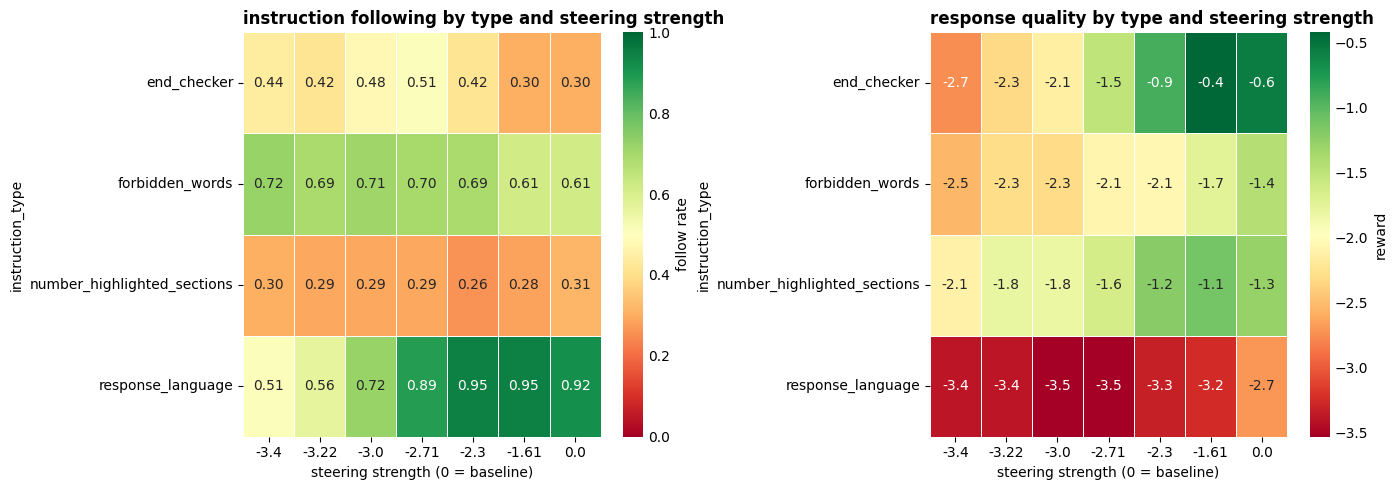

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

follow_pivot = instr_summary.pivot(index="instruction_type", columns="steering_strength", values="follow_rate")
reward_pivot = instr_summary.pivot(index="instruction_type", columns="steering_strength", values="mean_reward")

plot_metric_heatmap(
    follow_pivot,
    ax=axes[0],
    title="instruction following by type and steering strength",
    xlabel="steering strength (0 = baseline)",
    vmin=0, vmax=1,
    cbar_label="follow rate",
)

plot_metric_heatmap(
    reward_pivot,
    ax=axes[1],
    title="response quality by type and steering strength",
    xlabel="steering strength (0 = baseline)",
    fmt=".1f",
    cbar_label="reward",
)

plt.tight_layout()
plt.show()

## Takeaways

PASTA steering can improve instruction following, but the optimal alpha depends on the acceptable quality tradeoff. For this model and task, moderate steering (alpha in the range 10-20) typically offers the best balance between compliance and response quality.